# npx-384-hex-O1 location

author: steeve.laquitaine@epfl.ch  
date: 22.08.2023  
last modified: 22.08.2023  
status: OK
display status: OK
regression: None

## Setup 

Create and activate `npx_10m_384ch_unit_classes`

In [66]:
# SET PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import h5py
import MEAutility as MEA
from sklearn.decomposition import PCA

pd.set_option('display.max_colwidth', None)

# SET PATHS
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/bernstein_2023/"

os.chdir(PROJ_PATH)
from src.nodes.load import load_campaign_params
from src.nodes.truth.silico import ground_truth
from src.nodes.utils import get_config
from src.nodes.dataeng.silico.filtering import get_hex_01_cells, filter_microcircuit_cells
from src.nodes.utils import write_metadata
from src.nodes.dataeng.silico import probe_wiring
from src.nodes import viz 


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"       # specifies the experiment from conf/
SIMULATION_DATE = "2023_08_17"          # specifies the run (date)


# SETUP CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

CONTACT_IDS = param_conf["probe"]["neuropixels_384"]["contact_ids"]

# SET OUTPUT FIGURE PATHS
# FIG_PATH = data_conf["figures"]["silico"]["probe_location"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-08-22 16:34:03,991 - root - utils.py - get_config - INFO - Reading experiment config.
2023-08-22 16:34:04,010 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Get hex_O1 circuit

(See 3)

In the source code that generated the channel weight file, the seven-columns circuit (`hex_01`, `O1`) was used to position the probe (at its centroid).

In [67]:
# load campaign parameters
simulation = load_campaign_params(data_conf)

# get true sorting
SortingObject = ground_truth.load(data_conf)

# count near-contact cells
unit_count = SortingObject.get_num_units()
print("cell (count): ", unit_count)

# locate them
sorted_cell_location = simulation["circuit"].cells.get(SortingObject.unit_ids, properties=[ 
    'x','y','z'])

# get column circuit soma coord.
circuit = get_hex_01_cells(simulation)
print("circuit cell (count): ", len(circuit["soma_location"]))

2023-08-22 16:34:30,526 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-08-22 16:34:30,533 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


cell (count):  1116
circuit cell (count):  211712


### Check coords. in weight file

In [68]:
# set number of contacts
N_CHANNELS = 384

# get channel weight file path
weightspath = data_conf["campaign"]["source_weights"]

# read file
weight_file = h5py.File(weightspath, "r")
locationstmp = np.array([0, 0, 0])
contact_ids = []

for c_i in range(N_CHANNELS):

    # get contact ids from the weight file
    contact_id = str(list(weight_file["electrodes"].keys())[c_i][len("Neuropixels_384_"):])
    contact_ids.append(contact_id)

    # get the contacts' coordinates 
    temp = np.array(weight_file["electrodes"]["Neuropixels-384_" + contact_id]["location"])
    locationstmp = np.c_[locationstmp, temp]

# get contact ids and coordinates
file_coords = locationstmp.T[1:]
contact_ids = np.array(contact_ids)

# order contact ids and coordinates
sorted_ix = np.argsort(contact_ids.astype(int))
contact_ids = contact_ids.astype(int)[sorted_ix]
file_coords = file_coords[sorted_ix]

weight_file.close()

### Check against file source code with MEAUtilities

In [69]:
N_CHANNELS = 384
contact_ids = np.arange(0, N_CHANNELS, 1)
probe_name = "Neuropixels-384"

# create 384-contact probe
MeaNpx = MEA.return_mea(probe_name)

circuit = get_hex_01_cells(simulation)
somaPos = circuit["soma_location"]

center = np.mean(somaPos,axis=0).values
pca = PCA(n_components=3)
pca.fit(somaPos)
main_axis = pca.components_[0]
elevation = np.arctan2(np.sqrt(main_axis[0]**2+main_axis[1]**2),main_axis[2])
azimuth = np.arctan2(main_axis[1],main_axis[0])
MeaNpx.rotate([0,1,0],elevation*180/np.pi)
MeaNpx.rotate([0,0,1],azimuth*180/np.pi)
MeaNpx.move(center)

In [70]:
# sanity check
assert np.sum(MeaNpx.positions - file_coords) == 0, "MEA probe coordinates do not match file coordinates" 

### Check against our ProbeInterface reconstruction

In [64]:
# 40 secs
# wire recording with probe
Recording = probe_wiring.run(data_conf, param_conf)

# get contact coordinates
PiNpx = Recording.get_probe()

2023-08-22 16:33:00,035 - root - probe_wiring.py - run - INFO - probe: neuropixels_384_hex_O1


/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


In [65]:
# sanity check (acceptable error)
assert np.max(np.abs(PiNpx.contact_positions - file_coords)) < 1e-3, "MEA probe coordinates do not match file coordinates"

# sanity chech (error is acceptable, order of the nanometer)
np.max(np.abs(PiNpx.contact_positions - file_coords))

NameError: name 'file_coords' is not defined

### Compare

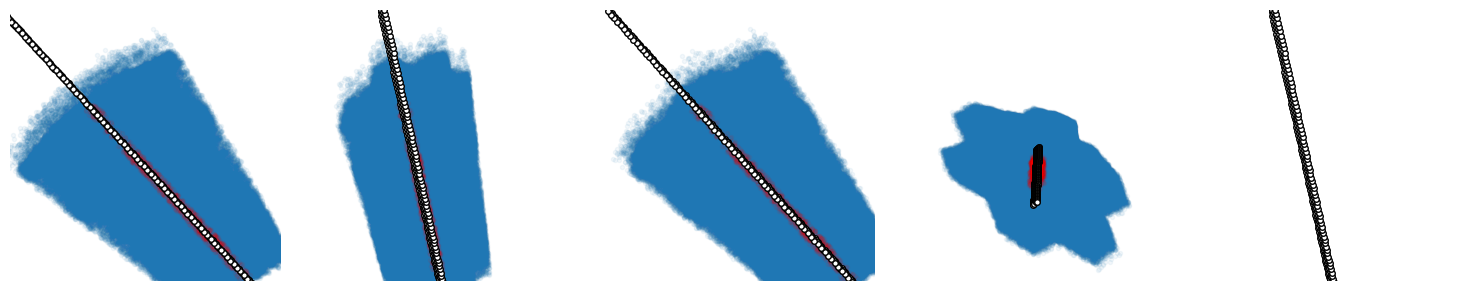

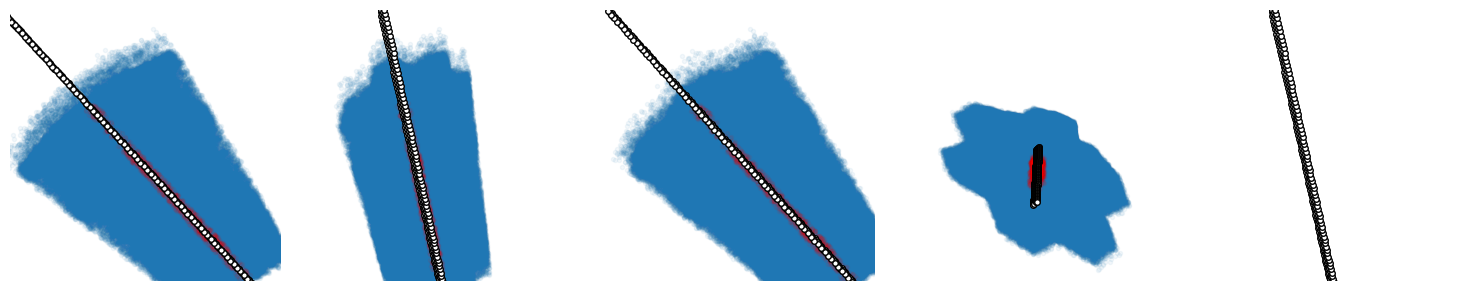

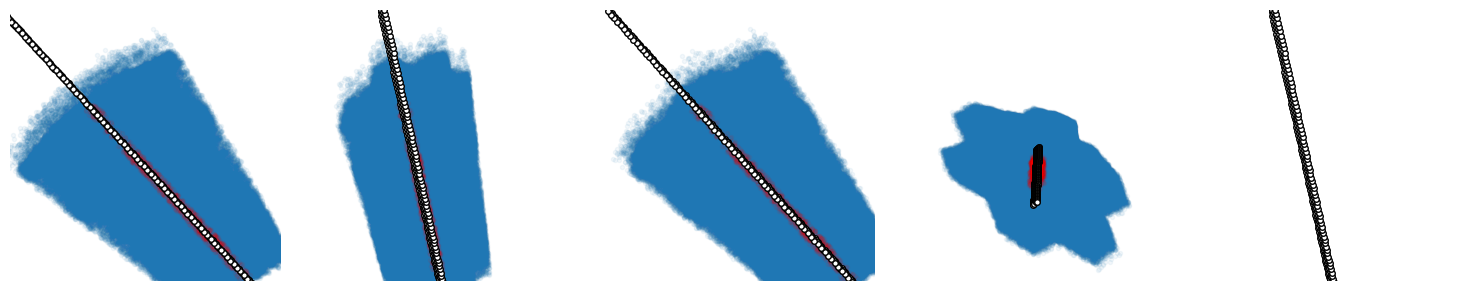

In [13]:
# plot probe with microcircuit and cell within 50 microns of the contacts
fig = viz.plot_probe_with_circuit(
    cell_coord=circuit["soma_location"],
    target_cell_coord=sorted_cell_location,
    probe_coord=file_coords,
    contact_ids=np.arange(0,384,1)
)

# plot probe with microcircuit and cell within 50 microns of the contacts
fig = viz.plot_probe_with_circuit(
    cell_coord=circuit["soma_location"],
    target_cell_coord=sorted_cell_location,
    probe_coord=MeaNpx.positions,
    contact_ids=np.arange(0,384,1)
)

# plot probe with microcircuit and cell within 50 microns of the contacts
fig = viz.plot_probe_with_circuit(
    cell_coord=circuit["soma_location"],
    target_cell_coord=sorted_cell_location,
    probe_coord=PiNpx.contact_positions,
    contact_ids=PiNpx.contact_ids,
)

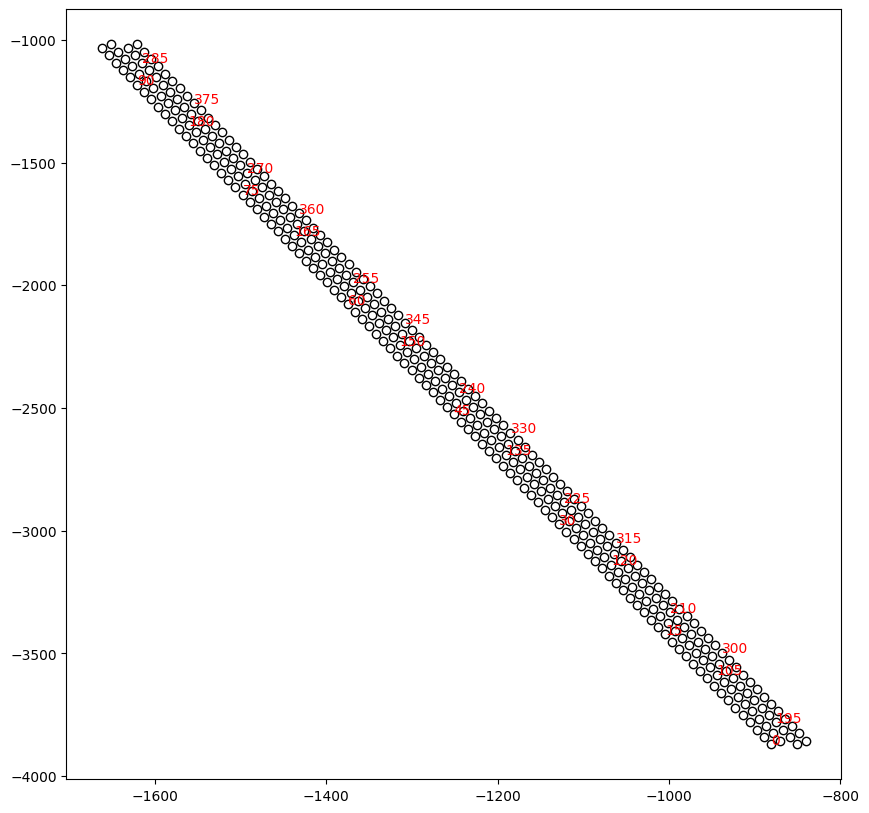

In [14]:
# plot file contact with ids 
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(file_coords[:,1], file_coords[:,2], "o", markerfacecolor="w", color="k");
for ix in range(len(contact_ids)):
    if ix % 15 == 0:
        ax.text(
            file_coords[ix, 1],
            file_coords[ix, 2],
            "%s" % (str(contact_ids[ix])),
            size=10,
            zorder=100,
            color="r",
        )

Our reconstructed coordinates

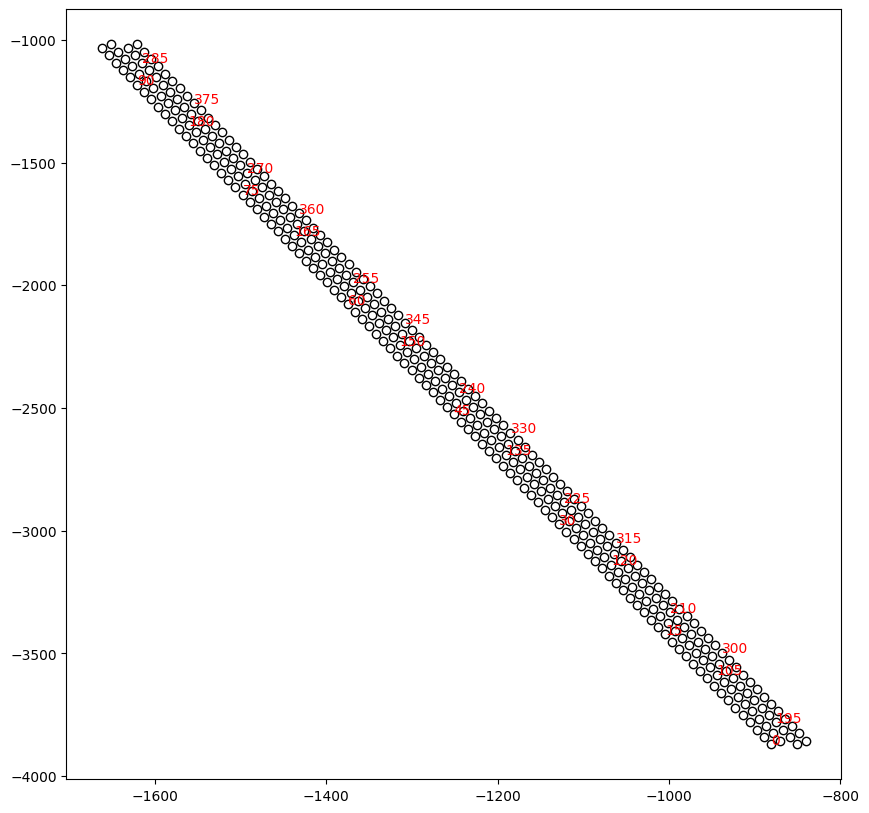

In [15]:
# plot file contact with ids 
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(PiNpx.contact_positions[:,1], PiNpx.contact_positions[:,2], "o", markerfacecolor="w", color="k");
for ix in range(len(contact_ids)):
    if ix % 15 == 0:
        ax.text(
            PiNpx.contact_positions[ix, 1],
            PiNpx.contact_positions[ix, 2],
            "%s" % (str(PiNpx.contact_ids[ix])),
            size=10,
            zorder=100,
            color="r",
        )

# References

(1) https://bbpgitlab.epfl.ch/nse/bluepy/-/blob/main/examples/ipython_notebooks/Usecase%201%20-%20Selecting%20cells%20from%20a%20circuit.ipynb 

(2) https://bbpteam.epfl.ch/documentation/projects/bluepy/latest/index.html 

(3) https://bbpteam.epfl.ch/documentation/projects/bluepy/latest/circuit.html 